# torch-betainc Visualization Notebook

This notebook provides comprehensive visualizations for the `torch-betainc` package, including:
- Incomplete beta function behavior
- Student's t-distribution CDF
- Gradient analysis
- Parameter sensitivity

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from torch_betainc import betainc, cdf_t

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## 1. Incomplete Beta Function Visualization

The regularized incomplete beta function $I_x(a, b)$ is defined as:

$$I_x(a, b) = \frac{B(x; a, b)}{B(a, b)}$$

where $B(x; a, b)$ is the incomplete beta function and $B(a, b)$ is the complete beta function.

### 1.1 Varying x for Fixed a and b

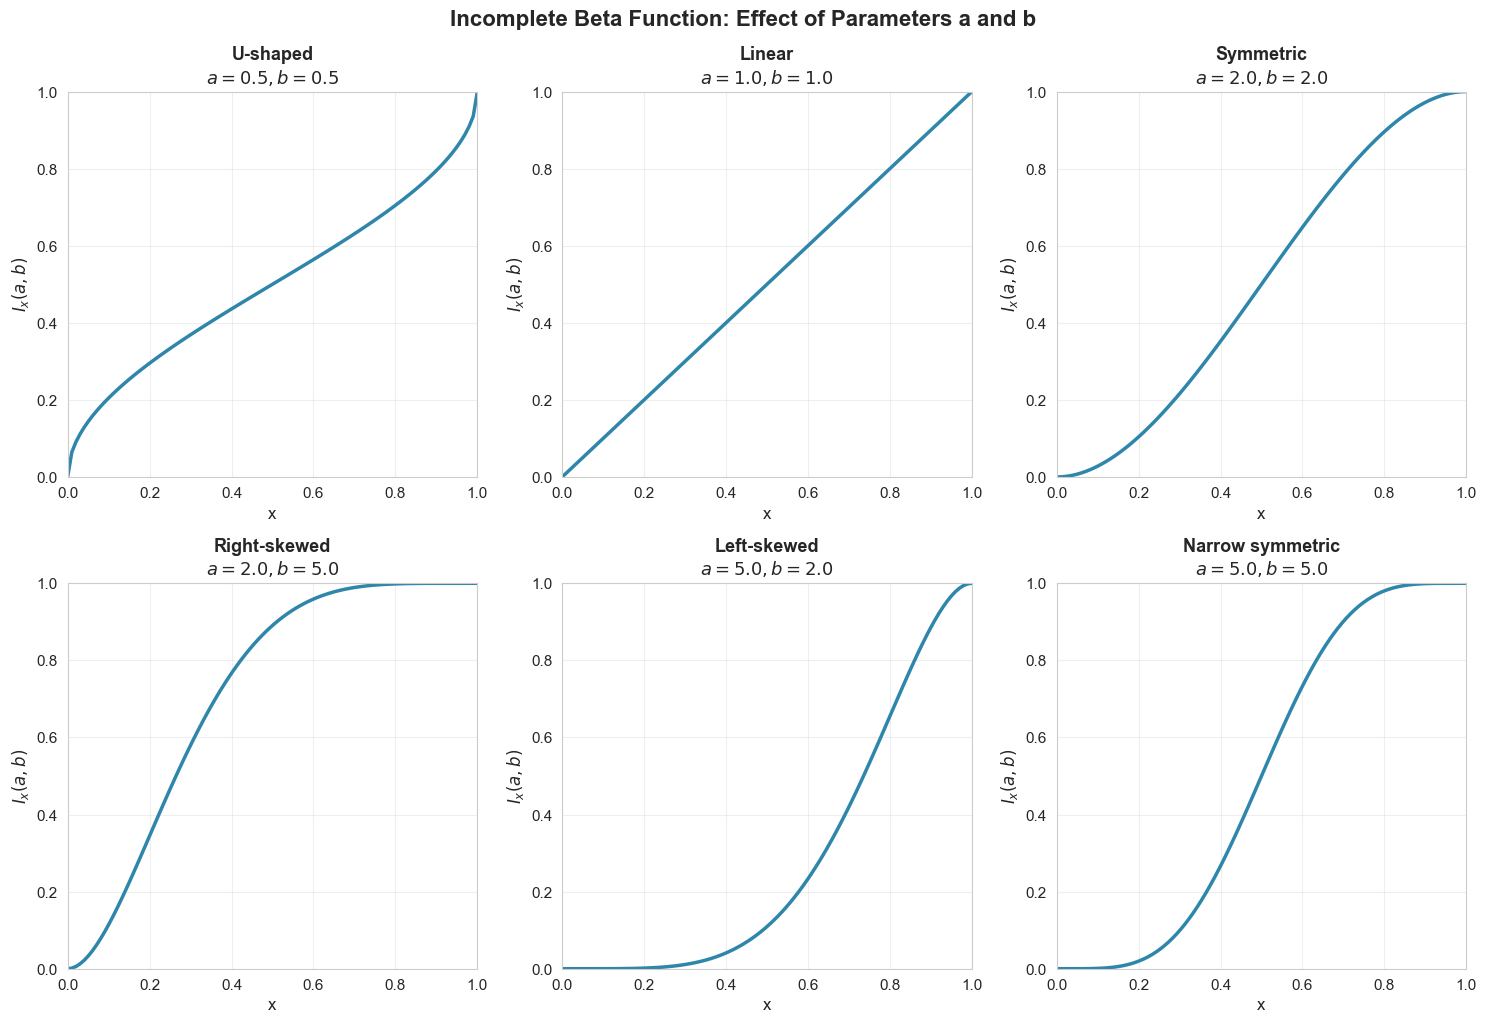

In [2]:
# Create a range of x values
x_values = torch.linspace(0, 1, 100)

# Different (a, b) parameter combinations
param_combinations = [
    (0.5, 0.5, 'U-shaped'),
    (1.0, 1.0, 'Linear'),
    (2.0, 2.0, 'Symmetric'),
    (2.0, 5.0, 'Right-skewed'),
    (5.0, 2.0, 'Left-skewed'),
    (5.0, 5.0, 'Narrow symmetric')
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (a_val, b_val, label) in enumerate(param_combinations):
    a = torch.tensor(a_val)
    b = torch.tensor(b_val)
    
    # Compute betainc for all x values
    results = [betainc(a, b, x).item() for x in x_values]
    
    axes[idx].plot(x_values.numpy(), results, linewidth=2.5, color='#2E86AB')
    axes[idx].set_xlabel('x', fontsize=12)
    axes[idx].set_ylabel('$I_x(a, b)$', fontsize=12)
    axes[idx].set_title(f'{label}\n$a={a_val}, b={b_val}$', fontsize=13, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim(0, 1)
    axes[idx].set_ylim(0, 1)

plt.tight_layout()
plt.suptitle('Incomplete Beta Function: Effect of Parameters a and b', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

### 1.2 3D Surface Plot: Varying a and b

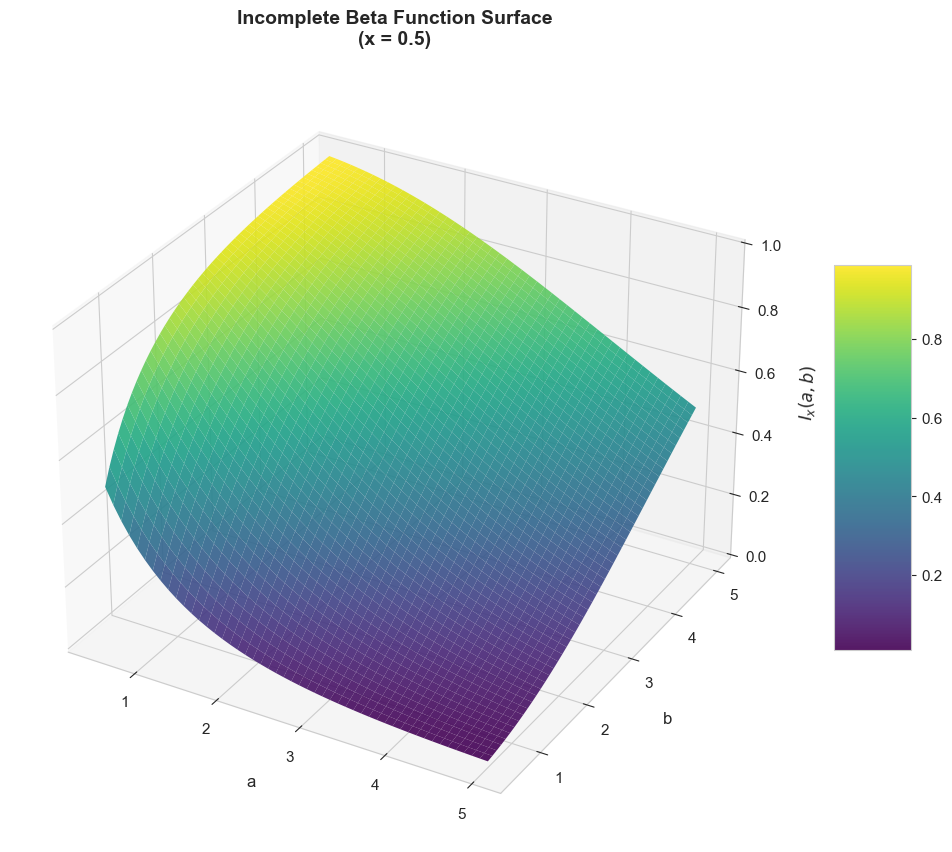

In [3]:
# Fixed x value
x_fixed = torch.tensor(0.5)

# Create meshgrid for a and b
a_range = torch.linspace(0.5, 5.0, 50)
b_range = torch.linspace(0.5, 5.0, 50)
A, B = torch.meshgrid(a_range, b_range, indexing='ij')

# Compute betainc for all combinations
Z = torch.zeros_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        Z[i, j] = betainc(A[i, j], B[i, j], x_fixed)

# Create 3D surface plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(A.numpy(), B.numpy(), Z.numpy(), 
                       cmap='viridis', alpha=0.9, edgecolor='none')

ax.set_xlabel('a', fontsize=12, labelpad=10)
ax.set_ylabel('b', fontsize=12, labelpad=10)
ax.set_zlabel('$I_x(a, b)$', fontsize=12, labelpad=10)
ax.set_title(f'Incomplete Beta Function Surface\n(x = {x_fixed.item()})', 
             fontsize=14, fontweight='bold', pad=20)

# Add colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()

### 1.3 Heatmap: Varying a and b

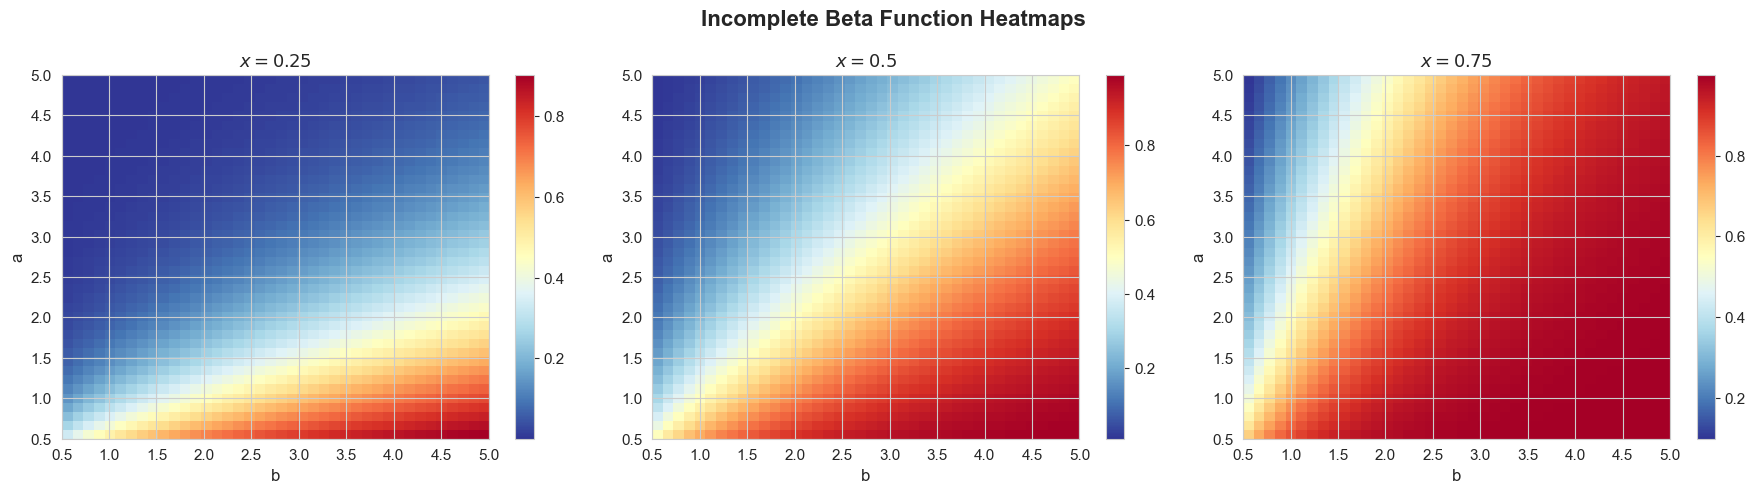

In [4]:
# Create heatmap for different x values
x_values_heatmap = [0.25, 0.5, 0.75]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, x_val in enumerate(x_values_heatmap):
    x_fixed = torch.tensor(x_val)
    
    # Create meshgrid
    a_range = torch.linspace(0.5, 5.0, 40)
    b_range = torch.linspace(0.5, 5.0, 40)
    A, B = torch.meshgrid(a_range, b_range, indexing='ij')
    
    # Compute betainc
    Z = torch.zeros_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            Z[i, j] = betainc(A[i, j], B[i, j], x_fixed)
    
    # Create heatmap
    im = axes[idx].imshow(Z.numpy(), origin='lower', cmap='RdYlBu_r', 
                          extent=[0.5, 5.0, 0.5, 5.0], aspect='auto')
    axes[idx].set_xlabel('b', fontsize=12)
    axes[idx].set_ylabel('a', fontsize=12)
    axes[idx].set_title(f'$x = {x_val}$', fontsize=13, fontweight='bold')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[idx])

plt.suptitle('Incomplete Beta Function Heatmaps', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 2. Student's t-Distribution CDF

The CDF of Student's t-distribution is computed using the incomplete beta function:

$$\text{CDF}(x) = \begin{cases}
1 - 0.5 \cdot I_{\frac{\nu}{\nu+t^2}}(\frac{\nu}{2}, \frac{1}{2}) & \text{if } t > 0 \\
0.5 \cdot I_{\frac{\nu}{\nu+t^2}}(\frac{\nu}{2}, \frac{1}{2}) & \text{if } t \leq 0
\end{cases}$$

where $t = \frac{x - \mu}{\sigma}$ and $\nu$ is the degrees of freedom.

### 2.1 t-Distribution CDF for Different Degrees of Freedom

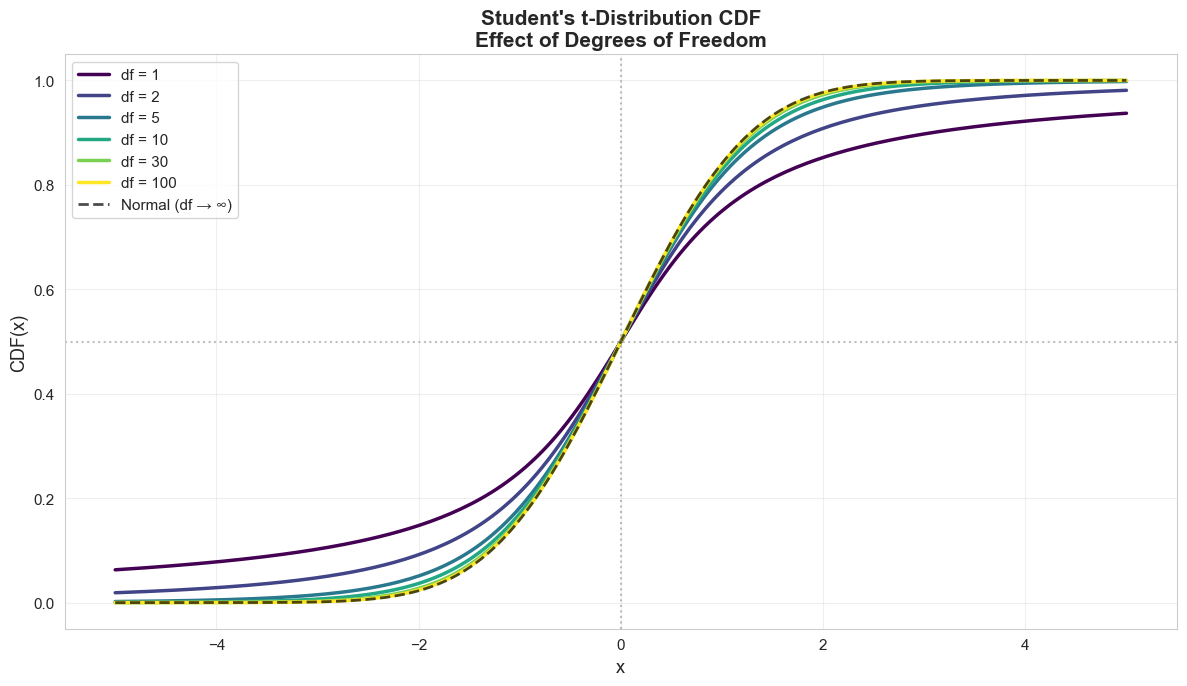

In [5]:
# Create range of x values
x_range = torch.linspace(-5, 5, 200)

# Different degrees of freedom
df_values = [1, 2, 5, 10, 30, 100]
colors = plt.cm.viridis(np.linspace(0, 1, len(df_values)))

plt.figure(figsize=(12, 7))

for df_val, color in zip(df_values, colors):
    df = torch.tensor(float(df_val))
    cdf_values = [cdf_t(x, df).item() for x in x_range]
    
    plt.plot(x_range.numpy(), cdf_values, linewidth=2.5, 
             label=f'df = {df_val}', color=color)

# Add normal distribution for comparison (df → ∞)
from scipy.stats import norm
normal_cdf = norm.cdf(x_range.numpy())
plt.plot(x_range.numpy(), normal_cdf, 'k--', linewidth=2, 
         label='Normal (df → ∞)', alpha=0.7)

plt.xlabel('x', fontsize=13)
plt.ylabel('CDF(x)', fontsize=13)
plt.title("Student's t-Distribution CDF\nEffect of Degrees of Freedom", 
          fontsize=15, fontweight='bold')
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

### 2.2 t-Distribution PDF (via Gradient)

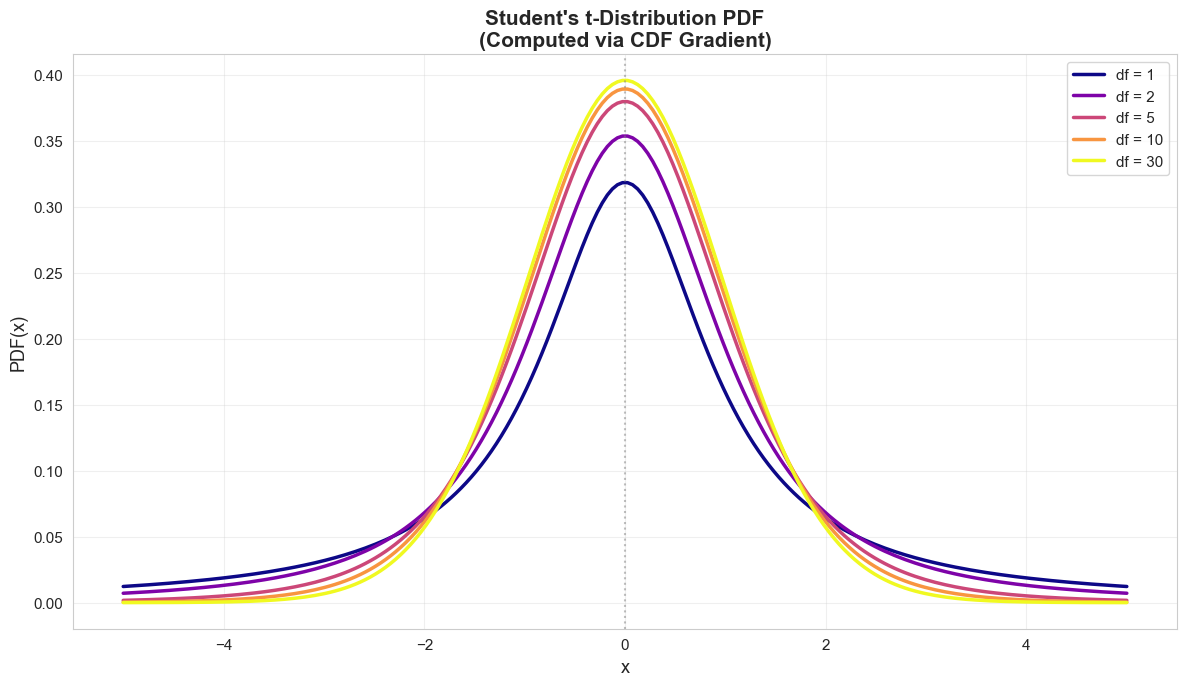

In [6]:
# Compute PDF as gradient of CDF
x_range = torch.linspace(-5, 5, 200, requires_grad=True)
df_values = [1, 2, 5, 10, 30]
colors = plt.cm.plasma(np.linspace(0, 1, len(df_values)))

plt.figure(figsize=(12, 7))

for df_val, color in zip(df_values, colors):
    df = torch.tensor(float(df_val))
    
    # Compute PDF values using gradient
    pdf_values = []
    for x in x_range:
        x_grad = x.clone().detach().requires_grad_(True)
        cdf_val = cdf_t(x_grad, df)
        cdf_val.backward()
        pdf_values.append(x_grad.grad.item())
    
    plt.plot(x_range.detach().numpy(), pdf_values, linewidth=2.5, 
             label=f'df = {df_val}', color=color)

plt.xlabel('x', fontsize=13)
plt.ylabel('PDF(x)', fontsize=13)
plt.title("Student's t-Distribution PDF\n(Computed via CDF Gradient)", 
          fontsize=15, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

### 2.3 t-Distribution with Location and Scale

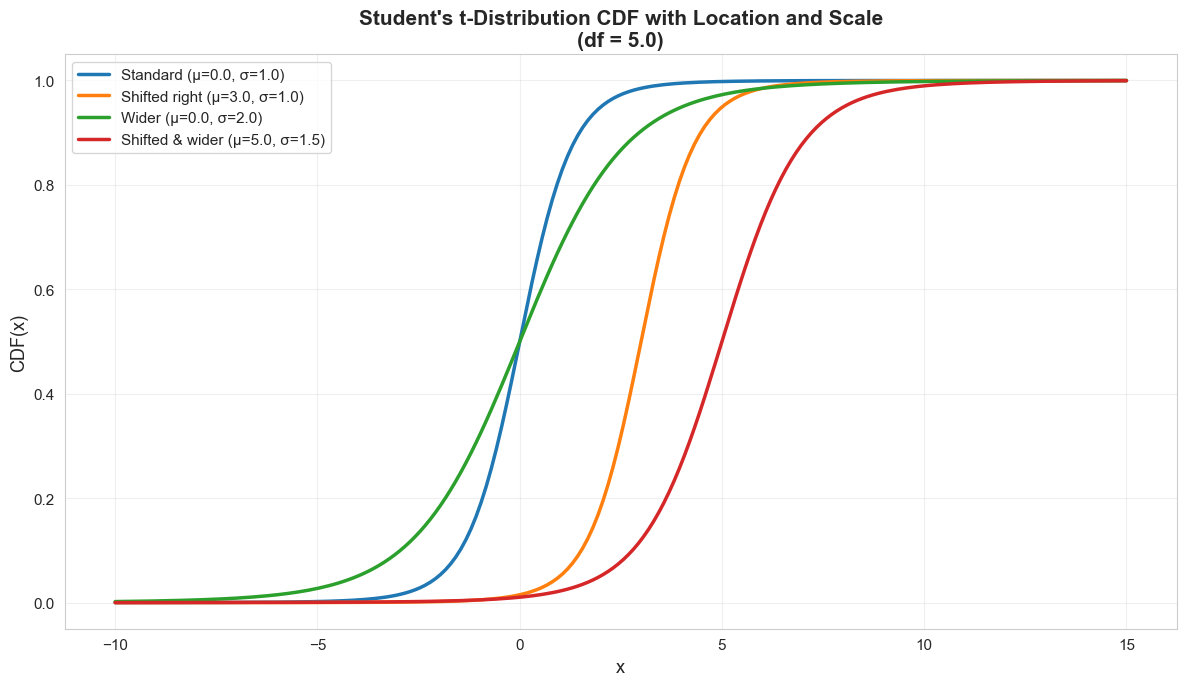

In [7]:
# Fixed degrees of freedom
df = torch.tensor(5.0)
x_range = torch.linspace(-10, 15, 200)

# Different location and scale parameters
params = [
    (0.0, 1.0, 'Standard'),
    (3.0, 1.0, 'Shifted right'),
    (0.0, 2.0, 'Wider'),
    (5.0, 1.5, 'Shifted & wider')
]

plt.figure(figsize=(12, 7))

for loc_val, scale_val, label in params:
    loc = torch.tensor(loc_val)
    scale = torch.tensor(scale_val)
    
    cdf_values = [cdf_t(x, df, loc, scale).item() for x in x_range]
    
    plt.plot(x_range.numpy(), cdf_values, linewidth=2.5, 
             label=f'{label} (μ={loc_val}, σ={scale_val})')

plt.xlabel('x', fontsize=13)
plt.ylabel('CDF(x)', fontsize=13)
plt.title(f"Student's t-Distribution CDF with Location and Scale\n(df = {df.item()})", 
          fontsize=15, fontweight='bold')
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Gradient Analysis

One of the key features of `torch-betainc` is full differentiability with respect to all parameters.

### 3.1 Gradients of Incomplete Beta Function

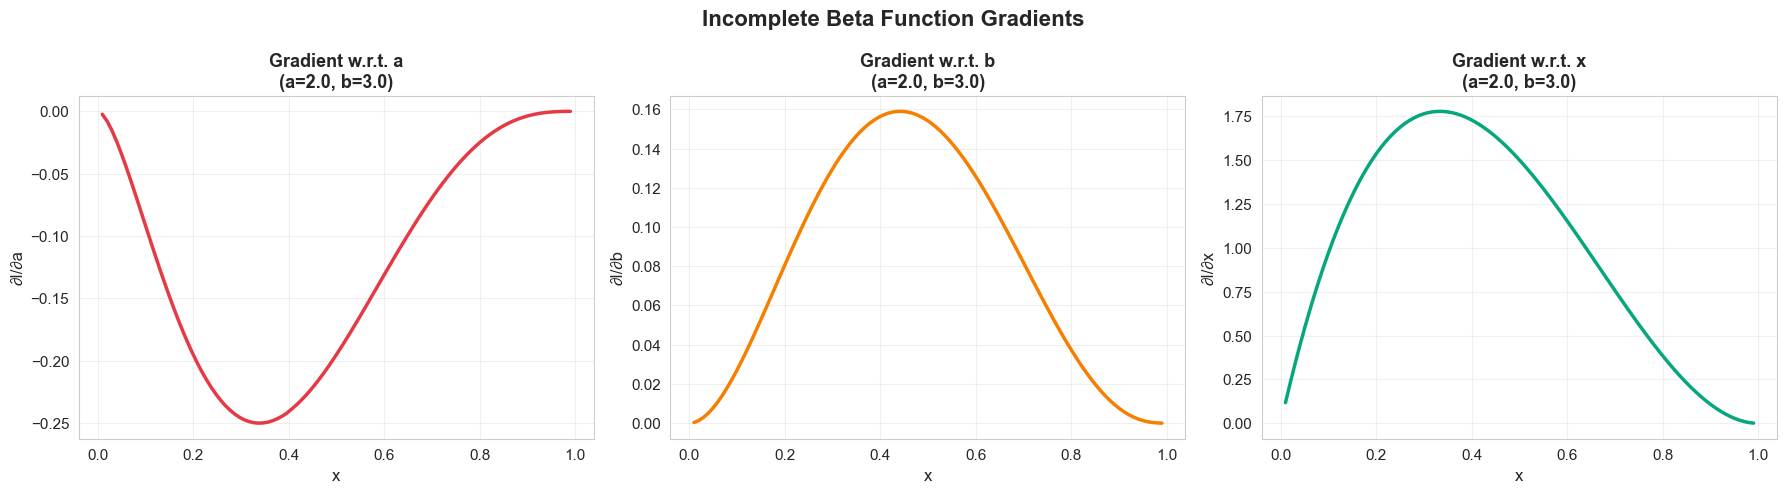

In [8]:
# Fixed a and b, vary x
a_fixed = torch.tensor(2.0)
b_fixed = torch.tensor(3.0)
x_range = torch.linspace(0.01, 0.99, 100)

# Compute gradients
grad_a_values = []
grad_b_values = []
grad_x_values = []

for x_val in x_range:
    a = a_fixed.clone().detach().requires_grad_(True)
    b = b_fixed.clone().detach().requires_grad_(True)
    x = x_val.clone().detach().requires_grad_(True)
    
    result = betainc(a, b, x)
    result.backward()
    
    grad_a_values.append(a.grad.item())
    grad_b_values.append(b.grad.item())
    grad_x_values.append(x.grad.item())

# Plot gradients
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(x_range.numpy(), grad_a_values, linewidth=2.5, color='#E63946')
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('∂I/∂a', fontsize=12)
axes[0].set_title(f'Gradient w.r.t. a\n(a={a_fixed.item()}, b={b_fixed.item()})', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(x_range.numpy(), grad_b_values, linewidth=2.5, color='#F77F00')
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('∂I/∂b', fontsize=12)
axes[1].set_title(f'Gradient w.r.t. b\n(a={a_fixed.item()}, b={b_fixed.item()})', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(x_range.numpy(), grad_x_values, linewidth=2.5, color='#06A77D')
axes[2].set_xlabel('x', fontsize=12)
axes[2].set_ylabel('∂I/∂x', fontsize=12)
axes[2].set_title(f'Gradient w.r.t. x\n(a={a_fixed.item()}, b={b_fixed.item()})', 
                  fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Incomplete Beta Function Gradients', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.2 Gradient Heatmap: ∂I/∂x

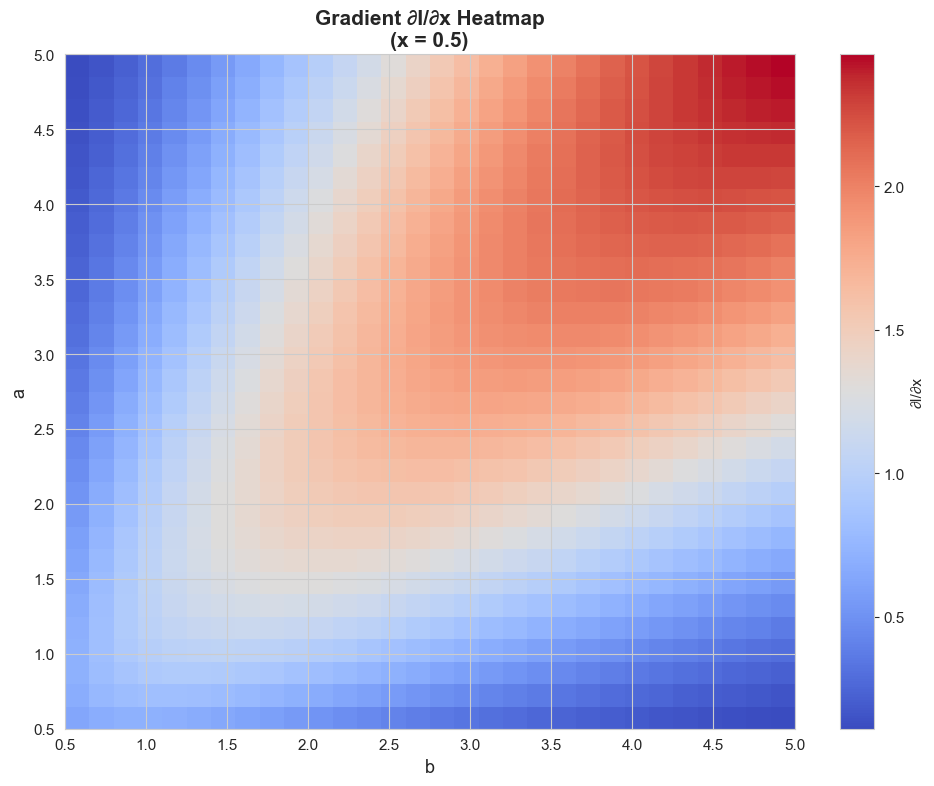

In [9]:
# Create meshgrid for a and b
a_range = torch.linspace(0.5, 5.0, 30)
b_range = torch.linspace(0.5, 5.0, 30)
x_fixed = torch.tensor(0.5)

# Compute gradient ∂I/∂x
grad_matrix = torch.zeros(len(a_range), len(b_range))

for i, a_val in enumerate(a_range):
    for j, b_val in enumerate(b_range):
        a = a_val.clone().detach()
        b = b_val.clone().detach()
        x = x_fixed.clone().detach().requires_grad_(True)
        
        result = betainc(a, b, x)
        result.backward()
        
        grad_matrix[i, j] = x.grad.item()

# Create heatmap
plt.figure(figsize=(10, 8))
im = plt.imshow(grad_matrix.numpy(), origin='lower', cmap='coolwarm', 
                extent=[0.5, 5.0, 0.5, 5.0], aspect='auto')
plt.colorbar(im, label='∂I/∂x')
plt.xlabel('b', fontsize=13)
plt.ylabel('a', fontsize=13)
plt.title(f'Gradient ∂I/∂x Heatmap\n(x = {x_fixed.item()})', 
          fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.3 t-Distribution CDF Gradients

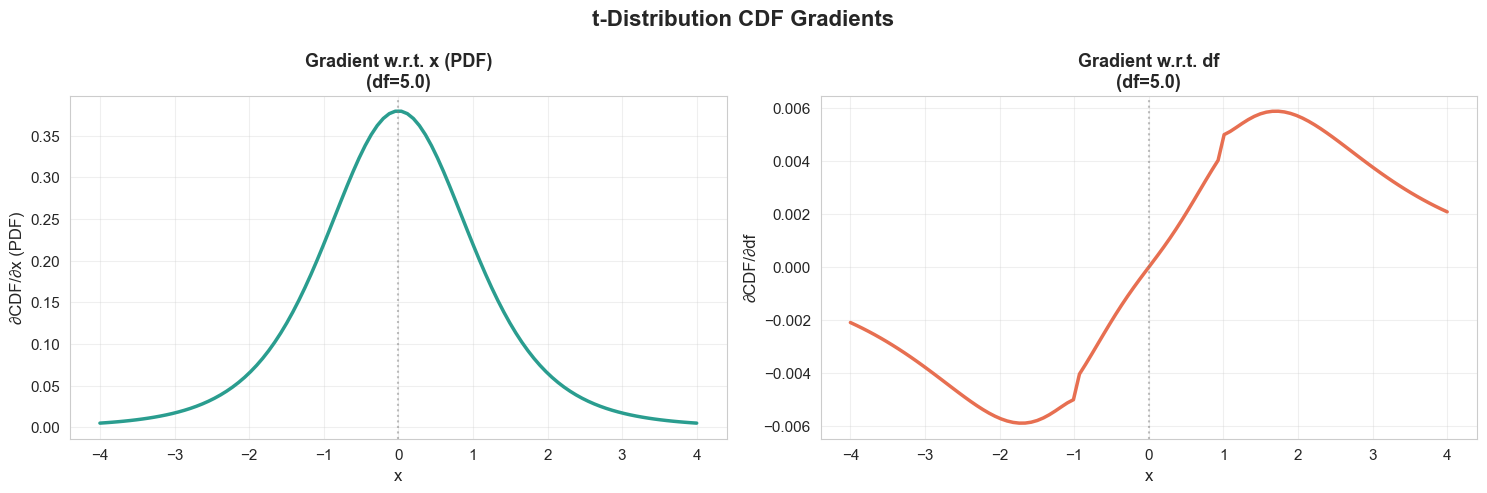

In [10]:
# Compute gradients for t-distribution CDF
x_range = torch.linspace(-4, 4, 100)
df_fixed = torch.tensor(5.0)

grad_x_values = []
grad_df_values = []

for x_val in x_range:
    x = x_val.clone().detach().requires_grad_(True)
    df = df_fixed.clone().detach().requires_grad_(True)
    
    result = cdf_t(x, df)
    result.backward()
    
    grad_x_values.append(x.grad.item())
    grad_df_values.append(df.grad.item())

# Plot gradients
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(x_range.numpy(), grad_x_values, linewidth=2.5, color='#2A9D8F')
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('∂CDF/∂x (PDF)', fontsize=12)
axes[0].set_title(f'Gradient w.r.t. x (PDF)\n(df={df_fixed.item()})', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=0, color='gray', linestyle=':', alpha=0.5)

axes[1].plot(x_range.numpy(), grad_df_values, linewidth=2.5, color='#E76F51')
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('∂CDF/∂df', fontsize=12)
axes[1].set_title(f'Gradient w.r.t. df\n(df={df_fixed.item()})', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=0, color='gray', linestyle=':', alpha=0.5)

plt.suptitle("t-Distribution CDF Gradients", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Parameter Sensitivity Analysis

### 4.1 Sensitivity to Parameter a

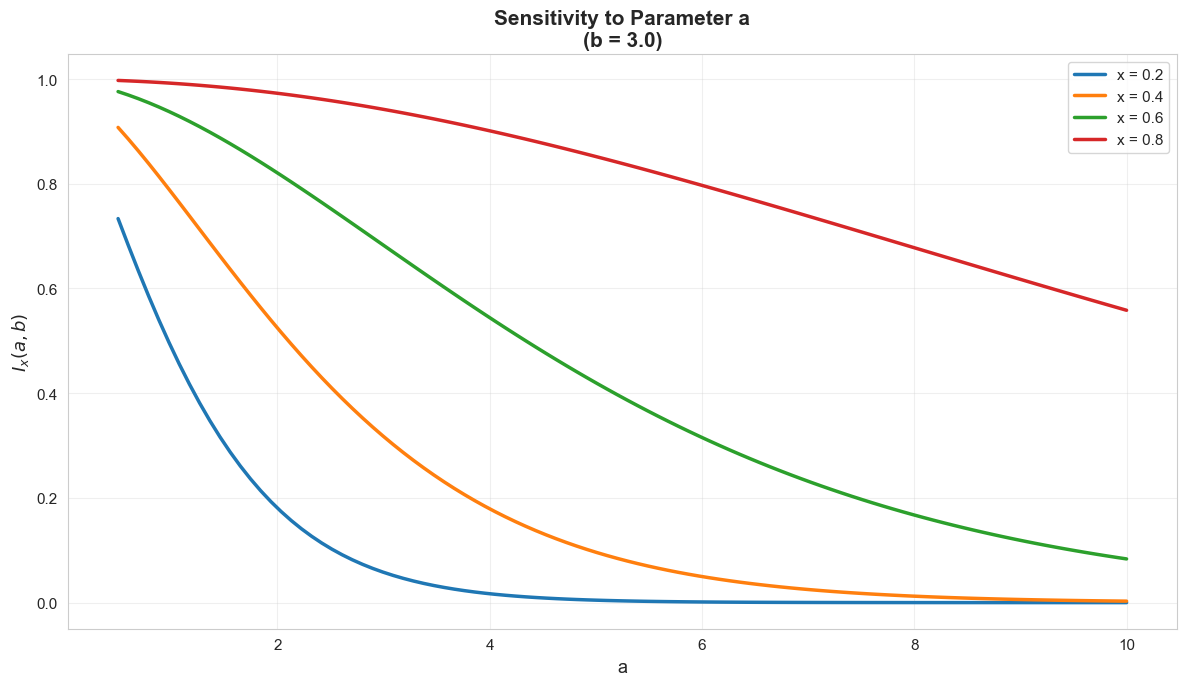

In [11]:
# Fixed b and x, vary a
b_fixed = torch.tensor(3.0)
x_values = [0.2, 0.4, 0.6, 0.8]
a_range = torch.linspace(0.5, 10.0, 100)

plt.figure(figsize=(12, 7))

for x_val in x_values:
    x = torch.tensor(x_val)
    results = [betainc(a, b_fixed, x).item() for a in a_range]
    
    plt.plot(a_range.numpy(), results, linewidth=2.5, label=f'x = {x_val}')

plt.xlabel('a', fontsize=13)
plt.ylabel('$I_x(a, b)$', fontsize=13)
plt.title(f'Sensitivity to Parameter a\n(b = {b_fixed.item()})', 
          fontsize=15, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.2 Sensitivity to Parameter b

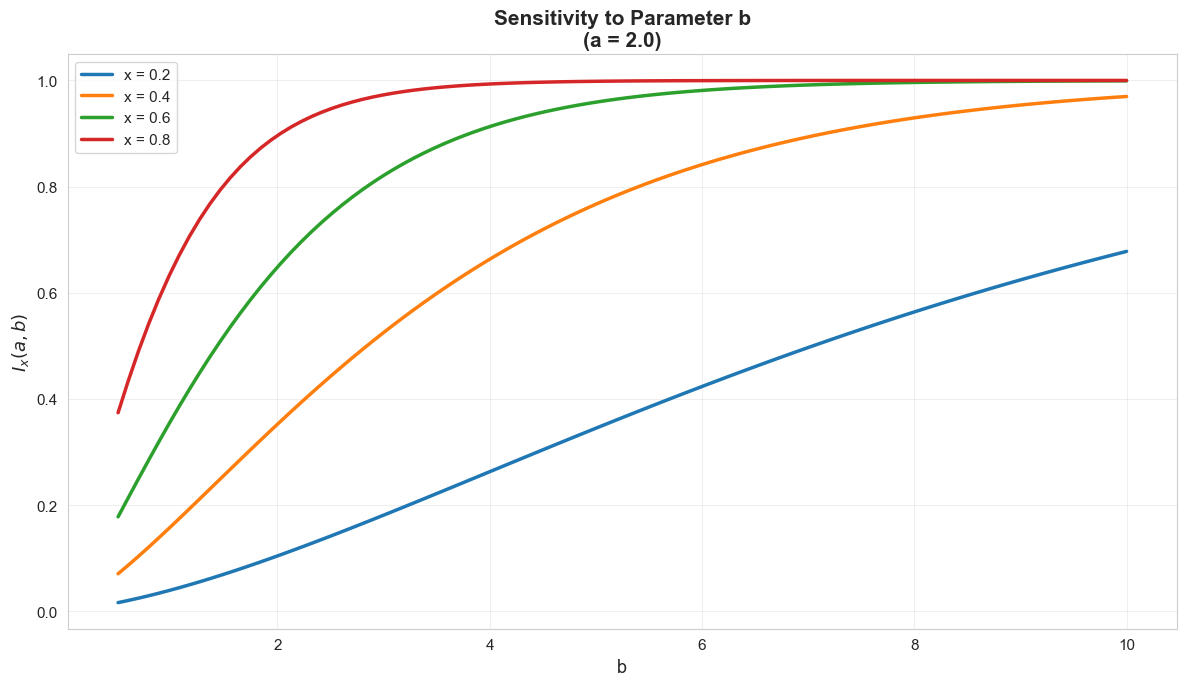

In [12]:
# Fixed a and x, vary b
a_fixed = torch.tensor(2.0)
x_values = [0.2, 0.4, 0.6, 0.8]
b_range = torch.linspace(0.5, 10.0, 100)

plt.figure(figsize=(12, 7))

for x_val in x_values:
    x = torch.tensor(x_val)
    results = [betainc(a_fixed, b, x).item() for b in b_range]
    
    plt.plot(b_range.numpy(), results, linewidth=2.5, label=f'x = {x_val}')

plt.xlabel('b', fontsize=13)
plt.ylabel('$I_x(a, b)$', fontsize=13)
plt.title(f'Sensitivity to Parameter b\n(a = {a_fixed.item()})', 
          fontsize=15, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Comparison with SciPy

Verify that our implementation matches SciPy's results.

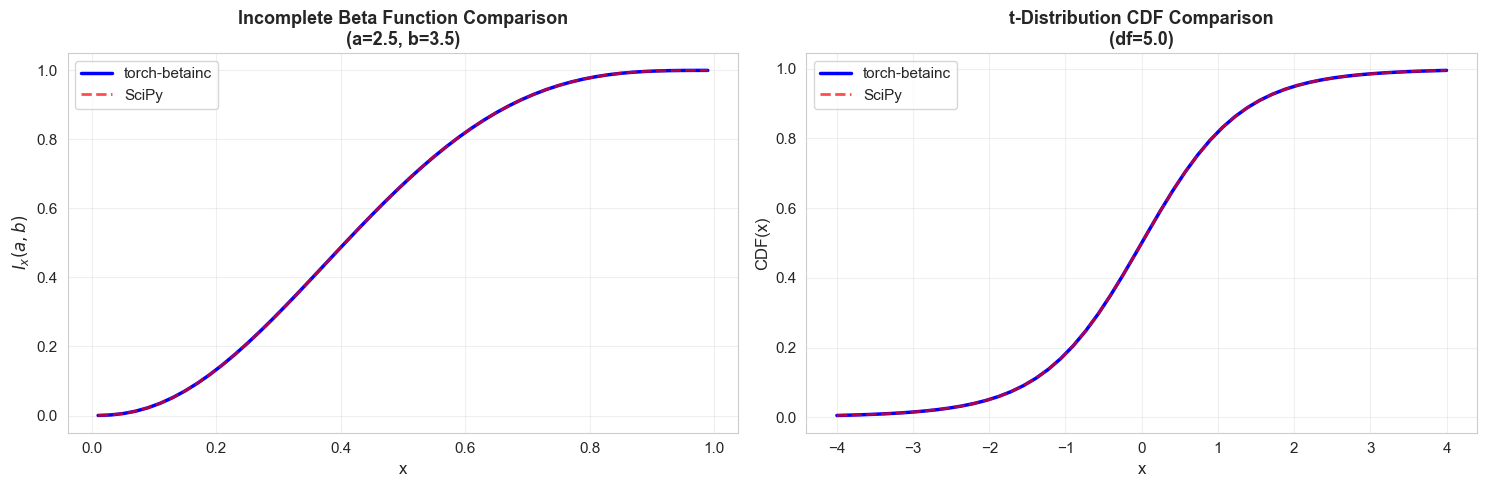

Maximum absolute error (betainc): 1.17e-07
Maximum absolute error (t-CDF): 3.95e-07


In [13]:
from scipy.special import betainc as scipy_betainc
from scipy.stats import t as scipy_t

# Test incomplete beta function
x_range = torch.linspace(0.01, 0.99, 50)
a_test = 2.5
b_test = 3.5

torch_results = [betainc(torch.tensor(a_test), torch.tensor(b_test), x).item() 
                 for x in x_range]
scipy_results = [scipy_betainc(a_test, b_test, x.item()) for x in x_range]

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Incomplete beta comparison
axes[0].plot(x_range.numpy(), torch_results, 'b-', linewidth=2.5, label='torch-betainc')
axes[0].plot(x_range.numpy(), scipy_results, 'r--', linewidth=2, label='SciPy', alpha=0.7)
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('$I_x(a, b)$', fontsize=12)
axes[0].set_title(f'Incomplete Beta Function Comparison\n(a={a_test}, b={b_test})', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# t-distribution CDF comparison
x_range_t = torch.linspace(-4, 4, 50)
df_test = 5.0

torch_t_results = [cdf_t(x, torch.tensor(df_test)).item() for x in x_range_t]
scipy_t_results = scipy_t.cdf(x_range_t.numpy(), df_test)

axes[1].plot(x_range_t.numpy(), torch_t_results, 'b-', linewidth=2.5, label='torch-betainc')
axes[1].plot(x_range_t.numpy(), scipy_t_results, 'r--', linewidth=2, label='SciPy', alpha=0.7)
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('CDF(x)', fontsize=12)
axes[1].set_title(f't-Distribution CDF Comparison\n(df={df_test})', 
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute maximum absolute error
max_error_beta = max(abs(t - s) for t, s in zip(torch_results, scipy_results))
max_error_t = max(abs(t - s) for t, s in zip(torch_t_results, scipy_t_results))

print(f"Maximum absolute error (betainc): {max_error_beta:.2e}")
print(f"Maximum absolute error (t-CDF): {max_error_t:.2e}")

## 6. Summary Statistics

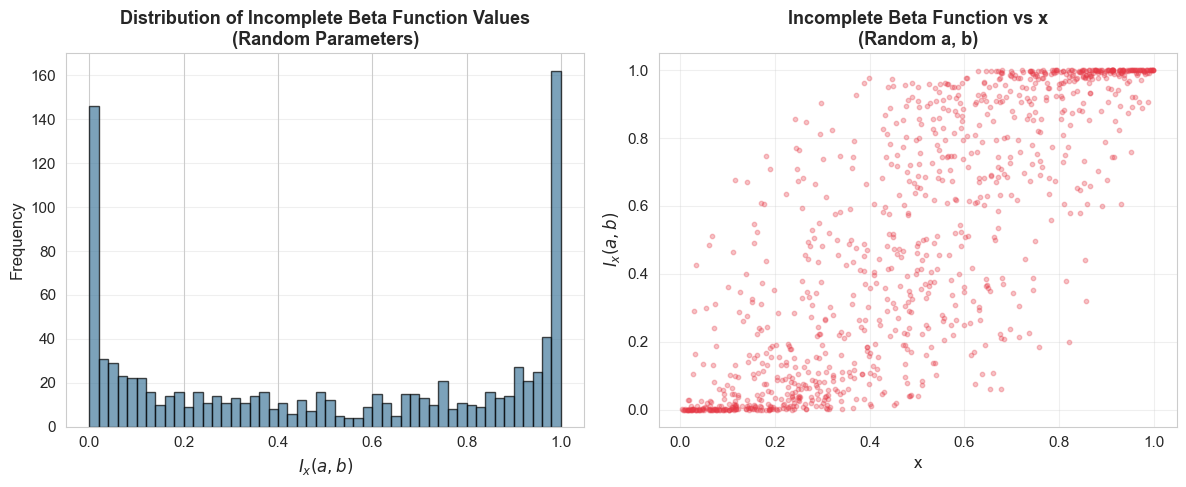

Mean: 0.5057
Std: 0.3842
Min: 0.0000
Max: 1.0000


In [14]:
# Generate random test cases
n_samples = 1000
torch.manual_seed(42)

a_samples = torch.rand(n_samples) * 5 + 0.5  # [0.5, 5.5]
b_samples = torch.rand(n_samples) * 5 + 0.5  # [0.5, 5.5]
x_samples = torch.rand(n_samples)  # [0, 1]

# Compute betainc for all samples
results = [betainc(a, b, x).item() for a, b, x in zip(a_samples, b_samples, x_samples)]

# Plot distribution of results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(results, bins=50, edgecolor='black', alpha=0.7, color='#457B9D')
plt.xlabel('$I_x(a, b)$', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Incomplete Beta Function Values\n(Random Parameters)', 
          fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
plt.scatter(x_samples.numpy(), results, alpha=0.3, s=10, color='#E63946')
plt.xlabel('x', fontsize=12)
plt.ylabel('$I_x(a, b)$', fontsize=12)
plt.title('Incomplete Beta Function vs x\n(Random a, b)', 
          fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean: {np.mean(results):.4f}")
print(f"Std: {np.std(results):.4f}")
print(f"Min: {np.min(results):.4f}")
print(f"Max: {np.max(results):.4f}")

## Conclusion

This notebook demonstrated:

1. **Incomplete Beta Function Behavior**: How the function varies with different parameters a, b, and x
2. **t-Distribution CDF**: Visualization of the CDF for different degrees of freedom and parameters
3. **Gradient Analysis**: Full differentiability with respect to all parameters
4. **Parameter Sensitivity**: How the function responds to changes in each parameter
5. **Validation**: Comparison with SciPy showing excellent agreement

The `torch-betainc` package provides a fully differentiable implementation that can be seamlessly integrated into PyTorch workflows for gradient-based optimization and machine learning applications.